In [1]:
from dataclasses import dataclass
from typing import List, Optional, Dict
from abc import ABC, abstractmethod

@dataclass
class Instruction:
    name: str
    dest: Optional[str]
    srcs: List[str]
    op: str = "ADD"

    def __str__(self):
        srcs = ",".join(self.srcs) if self.srcs else "-"
        dest = self.dest if self.dest else "-"
        return f"{self.name}({self.op} d={dest} s={srcs})"

NOP = Instruction(name="NOP", dest=None, srcs=[], op="NOP")

class HazardResolver(ABC):
    @abstractmethod
    def should_stall(self, pipeline: Dict[str, Instruction], incoming: Instruction) -> int:
        pass

class NoForwarding(HazardResolver):
    def should_stall(self, pipeline, incoming):
        if incoming is None or incoming == NOP or not incoming.srcs:
            return 0
        max_stall = 0
        stage_order = ["IF","ID","EX","MEM","WB"]
        for stage_idx, stage in enumerate(stage_order):
            instr = pipeline.get(stage, NOP)
            if instr and instr != NOP and instr.dest:
                for s in incoming.srcs:
                    if s == instr.dest:
                        remaining = (len(stage_order)-1) - stage_idx
                        if remaining > max_stall:
                            max_stall = remaining
        return max_stall

class Forwarding(HazardResolver):
    def should_stall(self, pipeline, incoming):
        if incoming is None or incoming == NOP or not incoming.srcs:
            return 0
        max_stall = 0
        early_stages = {"IF":2, "ID":1}
        for stage, delay in early_stages.items():
            instr = pipeline.get(stage, NOP)
            if instr and instr != NOP and instr.dest:
                for s in incoming.srcs:
                    if s == instr.dest and delay > max_stall:
                        max_stall = delay
        return max_stall


In [2]:
class PipelineSimulator:
    def __init__(self, instructions: List[Instruction], resolver: HazardResolver):
        self.instructions = instructions[:]
        self.resolver = resolver
        self.stages = ["IF","ID","EX","MEM","WB"]
        self.pipeline = {s: NOP for s in self.stages}
        self.cycle = 0
        self.pc = 0
        self.history = []

    def step(self):
        self.cycle += 1
        incoming = self.pipeline["IF"]
        stall_count = 0
        if incoming != NOP and incoming is not None:
            stall_count = self.resolver.should_stall(self.pipeline, incoming)
        if stall_count > 0:
            for _ in range(stall_count):
                self._shift_with_nop_in_id()
                self._record_snapshot()
                self.cycle += 1
        self._shift_pipeline()
        if self.pc < len(self.instructions):
            self.pipeline["IF"] = self.instructions[self.pc]
            self.pc += 1
        else:
            self.pipeline["IF"] = NOP
        self._record_snapshot()

    def _shift_with_nop_in_id(self):
        self.pipeline["WB"] = self.pipeline["MEM"]
        self.pipeline["MEM"] = self.pipeline["EX"]
        self.pipeline["EX"] = self.pipeline["ID"]
        self.pipeline["ID"] = NOP

    def _shift_pipeline(self):
        self.pipeline["WB"] = self.pipeline["MEM"]
        self.pipeline["MEM"] = self.pipeline["EX"]
        self.pipeline["EX"] = self.pipeline["ID"]
        self.pipeline["ID"] = self.pipeline["IF"]

    def _record_snapshot(self):
        snap = {s: self.pipeline[s] for s in self.stages}
        self.history.append((self.cycle, snap.copy()))

    def run(self, max_cycles=200):
        if self.pc < len(self.instructions):
            self.pipeline["IF"] = self.instructions[self.pc]
            self.pc += 1
        else:
            self.pipeline["IF"] = NOP
        self._record_snapshot()
        while (self.pc < len(self.instructions)) or any(self.pipeline[s] != NOP for s in self.stages):
            if self.cycle > max_cycles:
                break
            self.step()

    def pretty_print(self):
        print(f"{'Cycle':<6} | IF | ID | EX | MEM | WB")
        print("-" * 40)
        for cycle, snap in self.history:
            print(f"{cycle:<6} | " + " | ".join(snap[s].name for s in self.stages))
        print("\n")


In [3]:
def example_program():
    return [
        Instruction("I1", dest="R1", srcs=["R2","R3"], op="ADD"),
        Instruction("I2", dest="R4", srcs=["R1","R5"], op="ADD"),
        Instruction("I3", dest="R6", srcs=["R4","R1"], op="ADD"),
        Instruction("I4", dest="R7", srcs=["R8","R9"], op="ADD"),
        Instruction("I5", dest="R1", srcs=["R10","R11"], op="ADD"),
    ]

prog = example_program()

strategy_name = "Forwarding"
resolver = Forwarding() if strategy_name=="Forwarding" else NoForwarding()

sim = PipelineSimulator(prog, resolver)
sim.run()
print(f"Strategy: {strategy_name}\n")
sim.pretty_print()

sim_f = PipelineSimulator(prog, Forwarding())
sim_f.run()
cycles_f = sim_f.history[-1][0]

sim_n = PipelineSimulator(prog, NoForwarding())
sim_n.run()
cycles_n = sim_n.history[-1][0]

print(f"Total cycles with Forwarding   : {cycles_f}")
print(f"Total cycles with NoForwarding : {cycles_n}")
print(f"Stalls avoided by forwarding  : {cycles_n - cycles_f}")


Strategy: Forwarding

Cycle  | IF | ID | EX | MEM | WB
----------------------------------------
0      | I1 | NOP | NOP | NOP | NOP
1      | I2 | I1 | NOP | NOP | NOP
2      | I2 | NOP | I1 | NOP | NOP
3      | I3 | I2 | NOP | I1 | NOP
4      | I3 | NOP | I2 | NOP | I1
5      | I4 | I3 | NOP | I2 | NOP
6      | I5 | I4 | I3 | NOP | I2
7      | NOP | I5 | I4 | I3 | NOP
8      | NOP | NOP | I5 | I4 | I3
9      | NOP | NOP | NOP | I5 | I4
10     | NOP | NOP | NOP | NOP | I5
11     | NOP | NOP | NOP | NOP | NOP


Total cycles with Forwarding   : 11
Total cycles with NoForwarding : 15
Stalls avoided by forwarding  : 4


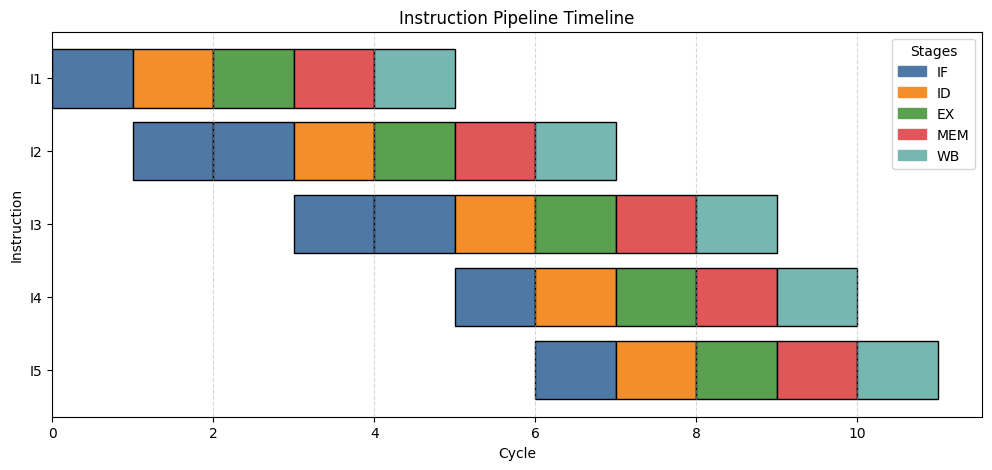

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_pipeline(simulator: PipelineSimulator):
    stages = simulator.stages
    stage_colors = {
        "IF": "#4e79a7",   # blue
        "ID": "#f28e2b",   # orange
        "EX": "#59a14f",   # green
        "MEM": "#e15759",  # red
        "WB": "#76b7b2",   # teal
    }

    fig, ax = plt.subplots(figsize=(12, 5))
    y_labels = []
    y_pos = []
    bar_height = 0.4

    instr_names = [ins.name for ins in simulator.instructions]
    for i, instr in enumerate(instr_names):
        y_labels.append(instr)
        y_pos.append(i)
        for cycle, snap in simulator.history:
            for stage in stages:
                if snap[stage].name == instr:
                    ax.barh(
                        y=i,
                        width=1,
                        left=cycle,
                        color=stage_colors[stage],
                        edgecolor='black'
                    )

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel("Cycle")
    ax.set_ylabel("Instruction")
    ax.set_title("Instruction Pipeline Timeline")
    ax.invert_yaxis()
    ax.grid(True, axis="x", linestyle="--", alpha=0.5)

    legend_patches = [mpatches.Patch(color=c, label=s) for s, c in stage_colors.items()]
    ax.legend(handles=legend_patches, title="Stages", loc="upper right")

    plt.show()

visualize_pipeline(sim)
